# **Human Scream Detection and Analysis for Controlling Crime Rate**

In [1]:
!pip install numpy pandas librosa scikit-learn matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00


In [2]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip


--2024-11-03 14:26:43--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-11-03 14:26:43--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-11-03 14:26:43--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ 

In [12]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
from IPython.display import display, Audio



# Load ESC-50 metadata
metadata = pd.read_csv('./ESC-50-master/meta/esc50.csv')

# Define target and non-target classes
scream_class = "crying_baby"  # Substitute scream with "crying_baby"
non_scream_classes = ["dog", "engine", "rain"]  # Non-alert sounds

metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [13]:
# Filter data for relevant classes
filtered_data = metadata[metadata['category'].isin([scream_class] + non_scream_classes)]
print("Filtered dataset size:", filtered_data.shape[0])

Filtered dataset size: 160


In [14]:
# Feature extraction function
def extract_features(row):
    file_path = os.path.join('./ESC-50-master/audio', row['filename'])
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

# Apply feature extraction and store features in the DataFrame
filtered_data['features'] = filtered_data.apply(extract_features, axis=1)
print("Features extracted successfully.")

# Check the number of samples per class
scream_data = filtered_data[filtered_data['category'] == scream_class]
non_scream_data = filtered_data[filtered_data['category'].isin(non_scream_classes)]

print("Number of crying baby samples:", len(scream_data))
print("Number of non-alert samples:", len(non_scream_data))

# Balance dataset by taking an equal number of samples for each class
min_class_count = min(len(scream_data), len(non_scream_data))
balanced_data = pd.concat([
    scream_data.sample(min_class_count, random_state=42),
    non_scream_data.sample(min_class_count, random_state=42)
])

Features extracted successfully.
Number of crying baby samples: 40
Number of non-alert samples: 120


<ipython-input-14-1f612e30aff0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['features'] = filtered_data.apply(extract_features, axis=1)


In [15]:


# Prepare features and labels
X = np.stack(balanced_data['features'].values)
y = balanced_data['category'].apply(lambda x: 1 if x == scream_class else 0).values

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)



SVC(kernel='linear', probability=True)

In [16]:

# Evaluate model performance
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

Confusion Matrix:
 [[6 2]
 [0 8]]


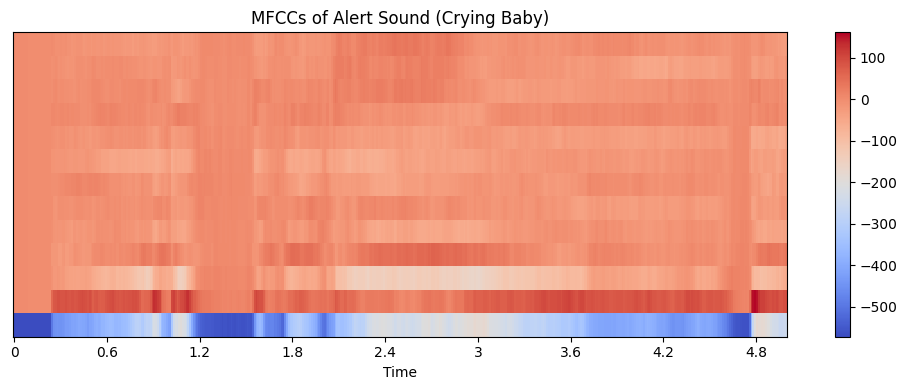

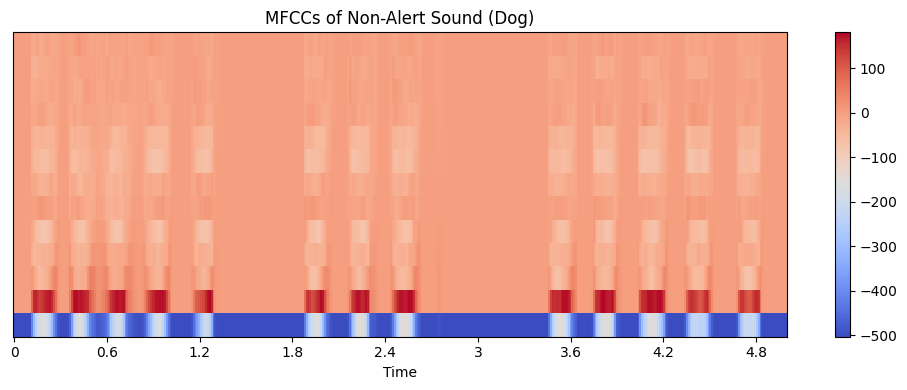

In [18]:
import random
import librosa.display

# Function to plot MFCCs
def plot_mfcc(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Select random alert and non-alert samples
alert_sample = filtered_data[filtered_data['category'] == scream_class].sample(1, random_state=42)
non_alert_sample = filtered_data[filtered_data['category'] == non_scream_classes[0]].sample(1, random_state=42)

# Plot MFCCs for an alert sound (e.g., "crying baby")
alert_file_path = os.path.join('./ESC-50-master/audio', alert_sample.iloc[0]['filename'])
plot_mfcc(alert_file_path, title="MFCCs of Alert Sound (Crying Baby)")

# Plot MFCCs for a non-alert sound (e.g., "dog")
non_alert_file_path = os.path.join('./ESC-50-master/audio', non_alert_sample.iloc[0]['filename'])
plot_mfcc(non_alert_file_path, title="MFCCs of Non-Alert Sound (Dog)")


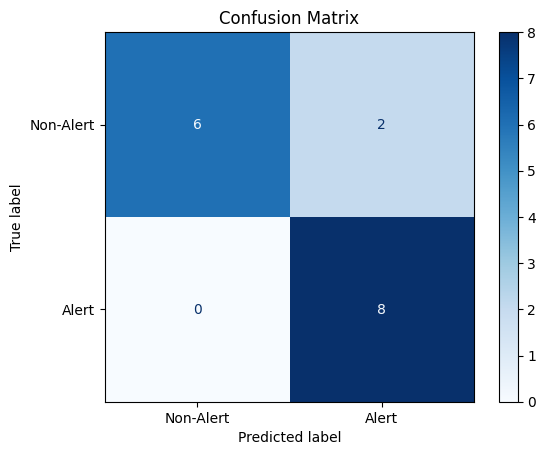

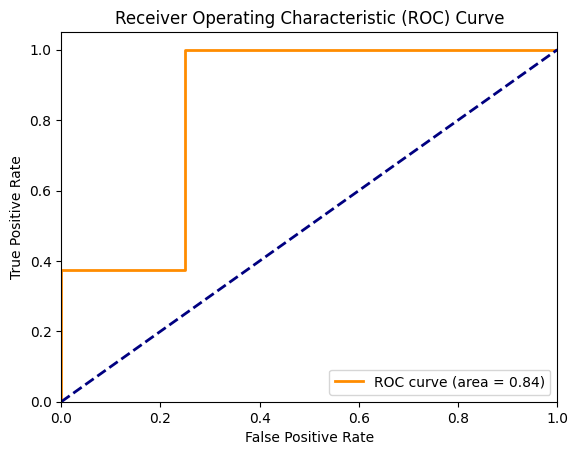

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Non-Alert", "Alert"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [19]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import librosa.display
import time

# Dark theme styling with responsive outline
dark_bg = '#1c1e24'
neon_blue = '#00f9ff'
neon_green = '#39ff14'
neon_pink = '#ff007f'
text_color = '#e0e0e0'
neon_black = '#000000'


# GUI title styling
title = widgets.HTML(
    "<h2 style='color:{}; text-align:center; margin: 10px 0px;font-size:25px'>Human Alert Sound Detection - GUI</h2>".format(neon_blue),
    layout=widgets.Layout(justify_content="center", width='100%')
)

# File upload and prediction elements with styling
file_upload = widgets.FileUpload(accept=".wav", multiple=False)
predict_button = widgets.Button(
    description="Predict",
    button_style="",
    layout=widgets.Layout(width='120px', height='40px'),
    style={'button_color': neon_black, 'font_weight': 'bold', 'font_size': '18px'}
)
sample_selector = widgets.Dropdown(
    options=["Select Sample"] + list(filtered_data['filename'].unique()),
    description="Samples:",
    layout=widgets.Layout(width='50%', color=neon_pink)
)
output_box = widgets.Output(layout=widgets.Layout(padding="10px", width="100%", overflow='auto'))

# Layout settings for widgets
file_upload.layout.width = '50%'
sample_selector.layout.width = '50%'
output_box.layout.height = 'auto'

# Define prediction function with highlighted details
def predict_sound(file):
    y, sr = librosa.load(file, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features = np.mean(mfccs.T, axis=0).reshape(1, -1)

    # Measure execution time
    start_time = time.time()

    # Make predictions
    prediction = model.predict(features)
    prediction_proba = model.predict_proba(features)[0]
    end_time = time.time()
    exec_time = end_time - start_time

    result = "Alert Sound Detected" if prediction[0] == 1 else "Non-Alert Sound"
    border_color = neon_pink if prediction[0] == 1 else neon_blue

    return result, prediction_proba, mfccs, exec_time, border_color

# Plot MFCCs for visualization
def plot_mfcc(mfccs, title):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(title, color=neon_blue)
    plt.tight_layout()
    plt.show()

# Set button functionality
def on_predict_button_clicked(b):
    output_box.clear_output()
    if sample_selector.value != "Select Sample":
        # Predict using selected sample from dataset
        file_path = os.path.join('./ESC-50-master/audio', sample_selector.value)
    elif len(file_upload.value) > 0:
        # Predict using uploaded file
        file_info = next(iter(file_upload.value.values()))
        file_path = file_info['content']
    else:
        with output_box:
            clear_output(wait=True)
            print("Please select a sample or upload a .wav file to predict.")
        return

    # Perform prediction
    result, proba, mfccs, exec_time, border_color = predict_sound(file_path)

    # Display the results in output box
    with output_box:
        clear_output(wait=True)
        output_box.layout.border = f"3px solid {border_color}"

        # Highlighted and centered prediction output
        display(widgets.HTML(
            f"<div style='text-align:center; color:{neon_pink if result == 'Alert Sound Detected' else neon_blue}; font-size:24px; font-weight:bold;'>" +
            f"Prediction: {result}</div>"
        ))

        # Highlighted confidence levels
        display(widgets.HTML(
            f"<div style='text-align:center; color:{neon_green}; font-size:18px;'>Confidence - Alert: {proba[1]*100:.2f}%, Non-Alert: {proba[0]*100:.2f}%</div>"
        ))

        # Execution time
        display(widgets.HTML(
            f"<div style='text-align:center; color:{text_color}; font-size:16px;'>Execution Time: {exec_time:.2f} seconds</div>"
        ))

        # Show MFCC plot within the bounded area
        print("\nMFCC Visualization:")
        plot_mfcc(mfccs, title="MFCCs of the Selected Sound")

        # Center-aligned Prediction Summary within a bordered box for visibility
        display(widgets.HTML(
            f"<div style='text-align:center; color:{neon_blue}; font-size:16px; margin-top: 10px; padding:10px; border:2px solid {neon_blue};'>" +
            f"<b>Prediction Summary:</b><br>" +
            ("The sound contains characteristics typical of an alert or scream-like sound." if result == "Alert Sound Detected"
             else "The sound does not contain characteristics typical of an alert or scream-like sound.") +
            "</div>"
        ))

# Attach button event
predict_button.on_click(on_predict_button_clicked)

# Display GUI with dark-themed structure and dynamic border for output box
app = widgets.VBox(
    [
        title,
        widgets.HTML("<hr style='border-color:{}; margin: 10px 0;'>".format(neon_blue)),
        widgets.HBox([sample_selector, file_upload, predict_button], layout=widgets.Layout(justify_content="center", padding="20px")),
        output_box,
        widgets.HTML(
            "<p style='text-align:center; color:{}; font-style:italic; font-size:16px;'>Created by AI Innovators</p>".format(neon_pink)
        )
    ],
    layout=widgets.Layout(
        width='80%',
        margin="20px auto",
        border=f'4px solid {neon_green}',
        padding="20px",
        background_color=dark_bg
    )
)
display(app)


# **HAPPY COADING**